In [55]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from gcn_lib import torch_nn as gcn_nn
from PIL import Image
from sklearn.neighbors import NearestNeighbors
from matplotlib.patches import Rectangle

device = device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
# # Set the seed for general torch operations
# torch.manual_seed(42)
# # Set the seed for CUDA torch operations (ones that happen on the GPU)
# torch.cuda.manual_seed(42)

cuda


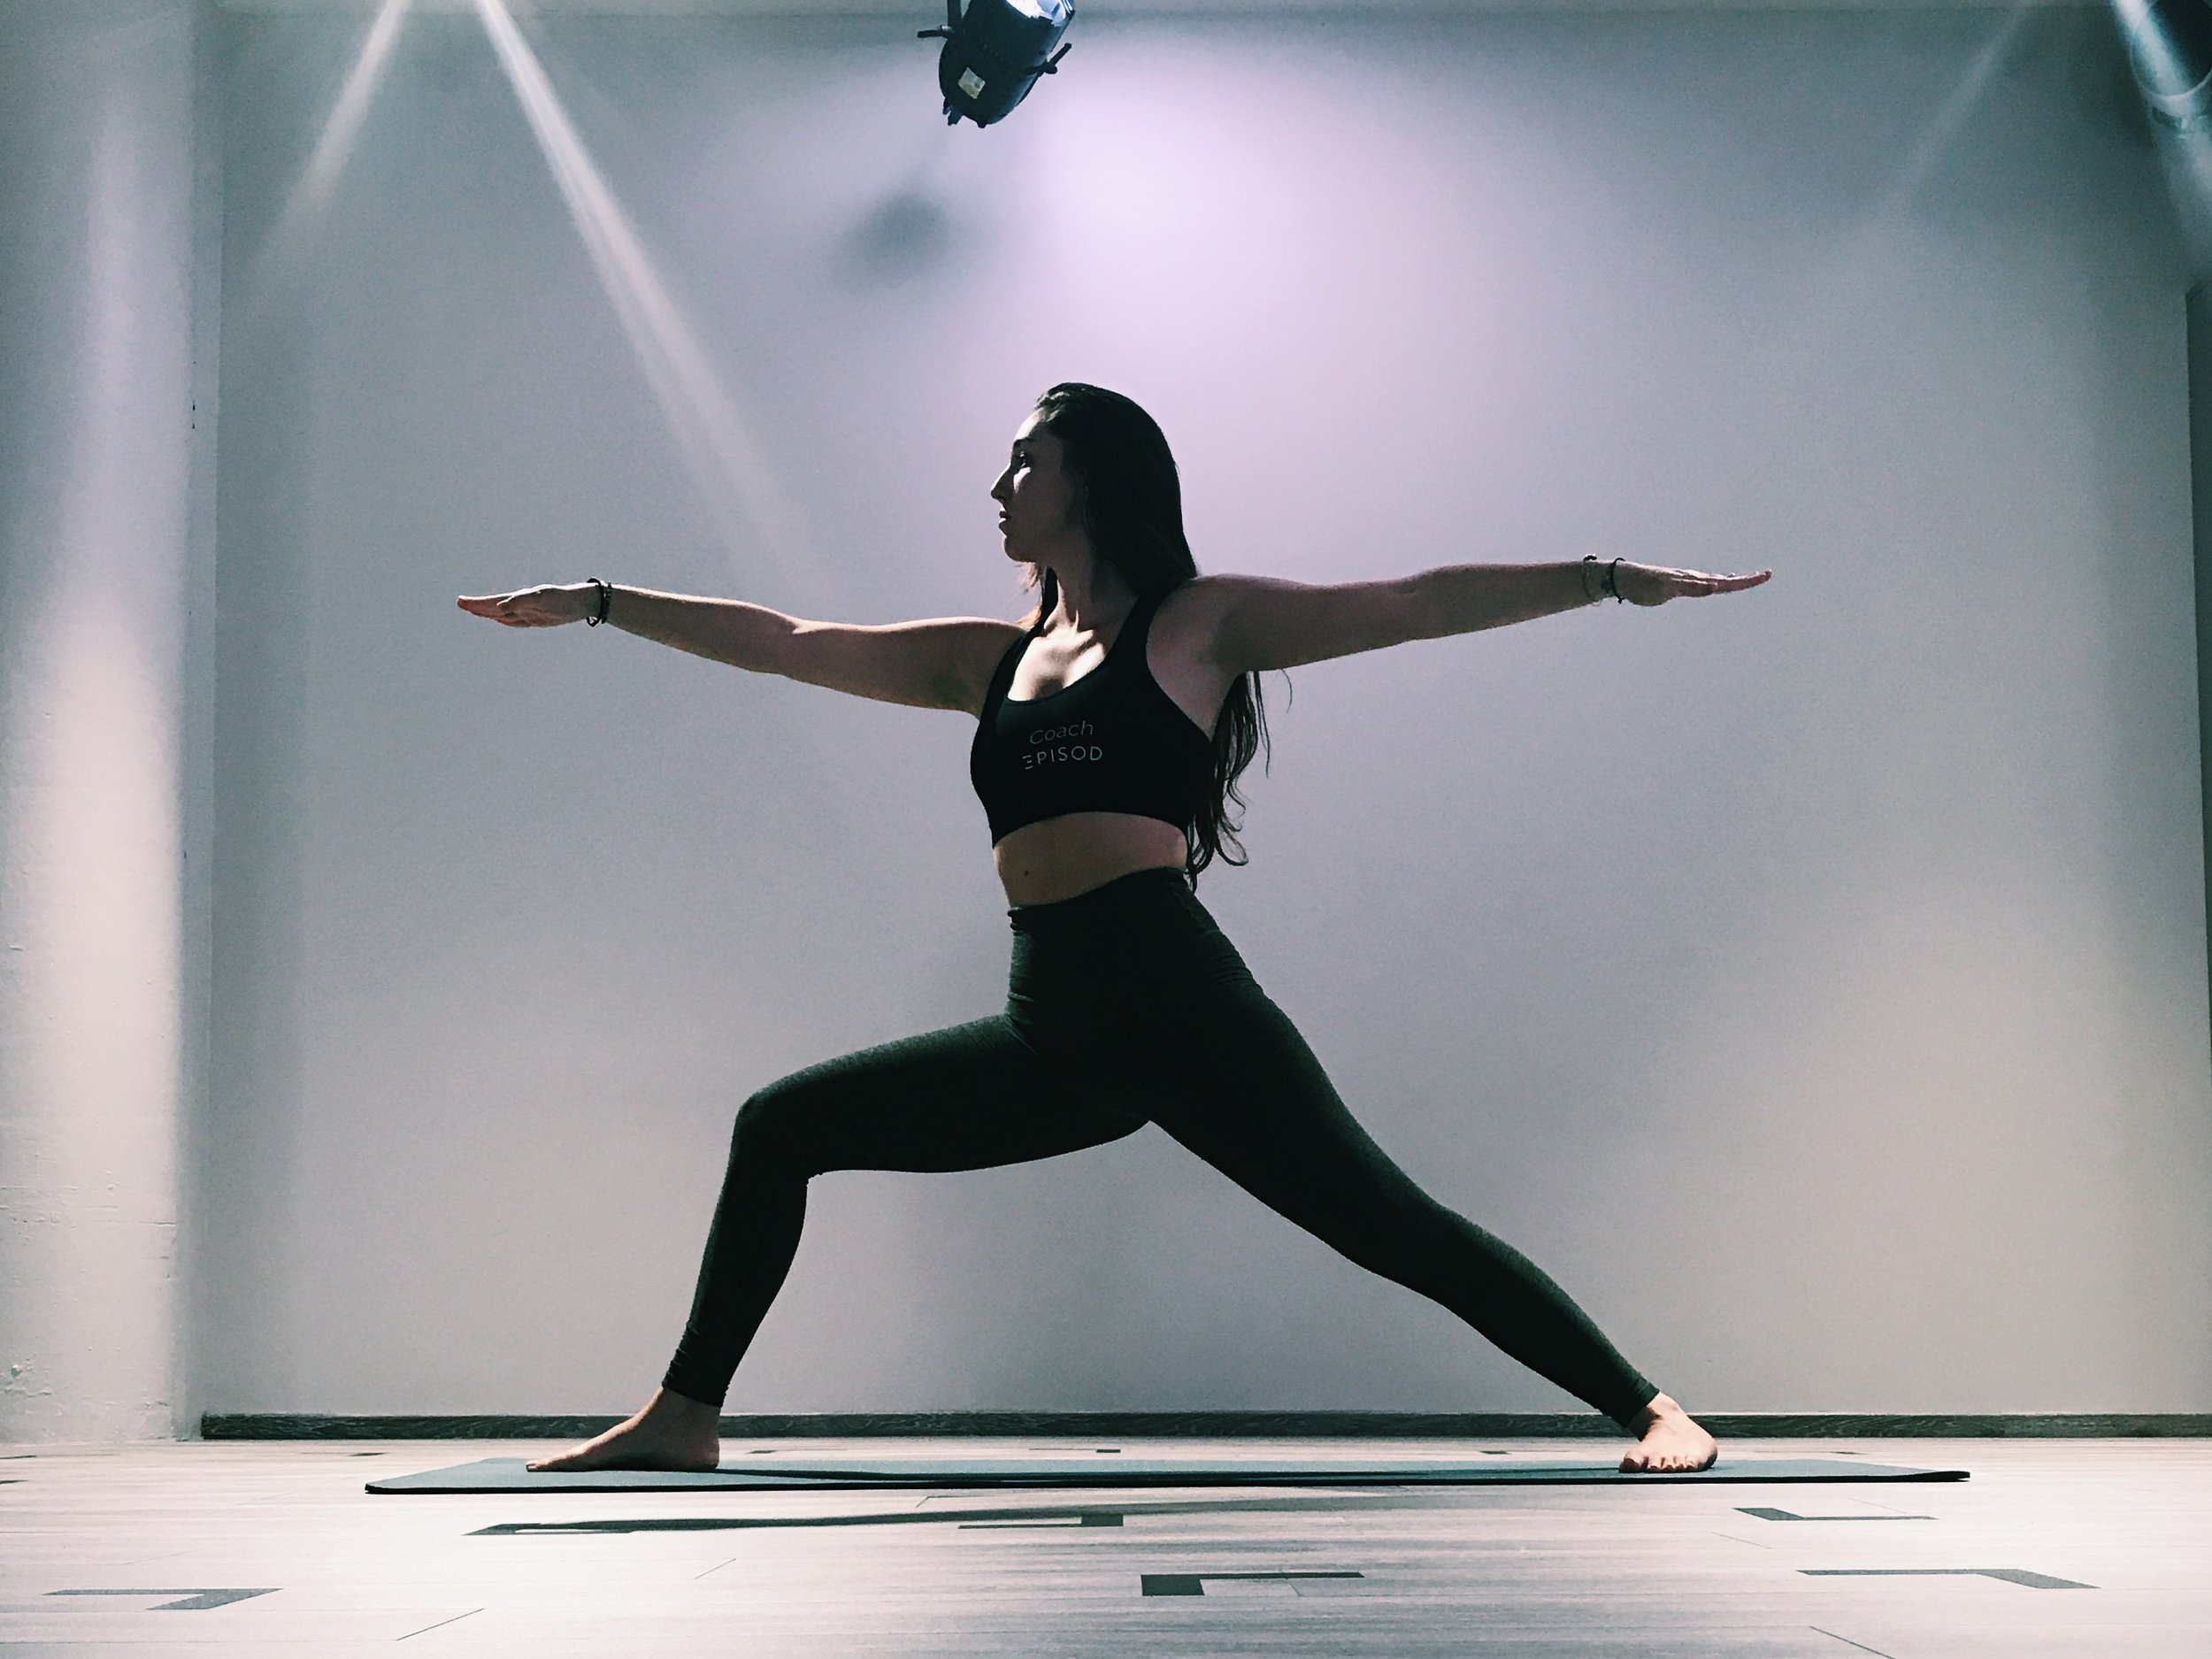

In [56]:
image = Image.open("./data/custom-data/warrior2.jpeg")

image

In [57]:
class Stem(nn.Module):
    """Image to Visual Word Embedding
    Overlap: https://arxiv.org/pdf/2106.13797.pdf
    """

    def __init__(self, img_size=224, in_dim=3, out_dim=768, act="gelu"):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_dim, out_dim // 8, 3, stride=2, padding=1),
            nn.BatchNorm2d(out_dim // 8),
            gcn_nn.act_layer(act),
            nn.Conv2d(out_dim // 8, out_dim // 4, 3, stride=2, padding=1),
            nn.BatchNorm2d(out_dim // 4),
            gcn_nn.act_layer(act),
            nn.Conv2d(out_dim // 4, out_dim // 2, 3, stride=2, padding=1),
            nn.BatchNorm2d(out_dim // 2),
            gcn_nn.act_layer(act),
            nn.Conv2d(out_dim // 2, out_dim, 3, stride=2, padding=1),
            nn.BatchNorm2d(out_dim),
            gcn_nn.act_layer(act),
            nn.Conv2d(out_dim, out_dim, 3, stride=1, padding=1),
            nn.BatchNorm2d(out_dim),
        )

    def forward(self, x):
        x = self.convs(x)
        return x


def extract_patches(image_tensor, patch_size):
    """
    Extract patches of a given size from an image tensor.

    Args:
        image_tensor (torch.Tensor): Input image tensor of shape (C, H, W).
        patch_size (int): Size of the patches to extract.

    Returns:
        torch.Tensor: Tensor of patches of shape (N, C, patch_size, patch_size),
            where N is the number of patches extracted.
    """
    batch_size, channels, height, width = image_tensor.size()

    unfold_shape = patch_size, patch_size
    patches = image_tensor.unfold(2, patch_size, step=patch_size).unfold(
        3, patch_size, step=patch_size
    )
    patches = patches.permute(0, 2, 3, 1, 4, 5).contiguous()
    patches = patches.view(-1, channels, *unfold_shape)

    return patches


def extract_features(image_tensor, patch_size, stem):
    patches = extract_patches(image_tensor, patch_size)
    batch_size, channels, height, width = image_tensor.size()
    out_dim = stem.convs[-2].out_channels  # Get the output channel dimension
    pos_embed = nn.Parameter(torch.zeros(1, out_dim, 14, 14)).to(device)
    features = stem(patches) + pos_embed
    return features


# Function to convert patch index to coordinates
def patch_index_to_coords(index, patch_size, img_width):
    num_patches_per_row = img_width // patch_size
    row = index // num_patches_per_row
    col = index % num_patches_per_row
    return row * patch_size, col * patch_size


# Function to visualize the node and its edges
def visualize_node_with_edges(
    image, adjacency_matrix, node_index, patch_size, img_width, k
):
    # Convert image tensor to numpy array
    image_np = image.cpu().squeeze().permute(1, 2, 0).numpy()

    # Plot the image
    fig, ax = plt.subplots()
    ax.imshow(image_np)

    # Get the coordinates of the selected node
    x, y = patch_index_to_coords(node_index, patch_size, img_width)

    # Draw the selected patch
    rect = Rectangle(
        (y, x), patch_size, patch_size, linewidth=2, edgecolor="r", facecolor="none"
    )
    ax.add_patch(rect)

    # Draw lines to the k-nearest neighbors
    for neighbor_index in range(adjacency_matrix[node_index].shape[0]):
        if adjacency_matrix[node_index][neighbor_index] == 1:
            nx, ny = patch_index_to_coords(neighbor_index, patch_size, img_width)
            ax.plot(
                [y + patch_size / 2, ny + patch_size / 2],
                [x + patch_size / 2, nx + patch_size / 2],
                "g",
            )
            neighbor_rect = Rectangle(
                (ny, nx),
                patch_size,
                patch_size,
                linewidth=2,
                edgecolor="b",
                facecolor="none",
            )
            ax.add_patch(neighbor_rect)
    plt.show()

In [58]:
# Parameters
node_index = 90  # Example node index to visualize
patch_size = 16
img_width = 224
k = 9  # Number of nearest neighbors

In [59]:
from torchvision.transforms import v2

preprocess = v2.Compose(
    [
        v2.ToImage(),
        v2.Resize((224, 224)),
        v2.ToDtype(torch.float32, scale=True),
    ]
)

image_tensor = preprocess(image).unsqueeze(dim=0).to(device)

stem_module = Stem(img_size=224, in_dim=3, out_dim=192, act="gelu").to(device)

stem_module.eval()
with torch.inference_mode():
    features = extract_features(image_tensor, patch_size, stem_module)
    print(f"Features tensor shape: {features.size()}")


# Flatten the spatial dimensions
num_patches, out_dim, h, w = features.shape
features_reshaped = features.view(num_patches, -1)

knn = NearestNeighbors(
    n_neighbors=k
)  # k+1 because the closest neighbor is the point itself
knn.fit(features_reshaped.cpu().detach().numpy())  # Convert to numpy and fit
distances, indices = knn.kneighbors(features_reshaped.cpu().detach().numpy())


# Initialize adjacency matrix
adjacency_matrix = torch.zeros((num_patches, num_patches), device=device)

# Create edges in the adjacency matrix
for i in range(num_patches):
    neighbors = indices[i][1 : k + 1]  # Ensure exactly k neighbors
    for j in neighbors:
        adjacency_matrix[i, j] = 1

print(adjacency_matrix)

Features tensor shape: torch.Size([196, 192, 14, 14])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 1.],
        [0., 0., 0.,  ..., 1., 0., 1.],
        [0., 0., 0.,  ..., 1., 1., 0.]], device='cuda:0')


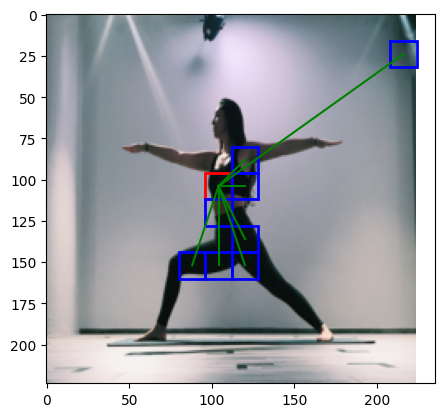

In [60]:
visualize_node_with_edges(
    image_tensor, adjacency_matrix, node_index, patch_size, img_width, k
)